In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import geopandas as gpd

In [74]:
df = pd.read_csv('Dataset/Crime_Dataset_Coursework1.csv', low_memory=False)
print('Dataframe Imported')

Dataframe Imported


In [75]:
#Custom dataframe to be used for certain visualisations
df_D =df.copy()
print('Dataframe copied to df_D')

Dataframe copied to df_D


In [76]:
def cleanup(df):
    #Remove unused columns
    df = df.drop(['Offence Code', 'CR Number', 'Victims', 'Crime Name3', 'Block Address', 'State', 'Zip Code', 'Agency', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Type', 'Street Suffix', 'End_Date_Time', 'Police District Number', 'Location'], axis=1)
    df['Place'] = df['Place'].str.split('-').str[0] # Used to simplify the Place column
    #df = df[df['City'].str.match(r'^[a-zA-Z]+$')] # Used to remove the City column with any other value than characters
    df_1 = df[df['City'] != '0']  # Filter the dataset by removing rows where `City` is '0'
    return df_1

In [77]:
def dfsize(df1, df2):
        
    memory_usage_df1 = df1.memory_usage(deep=True).sum()
    memory_usage_df2 = df2.memory_usage(deep=True).sum()

    difference_bytes = memory_usage_df1 - memory_usage_df2
    difference_percent = (difference_bytes / memory_usage_df1) * 100

    print(f"Memory usage of DataFrame 1: {memory_usage_df1} bytes")
    print(f"Memory usage of DataFrame 2: {memory_usage_df2} bytes")
    print(f"Difference: {difference_bytes} bytes")
    print(f"Percentage difference: {difference_percent:.2f}%")



In [81]:
df_D = cleanup(df_D)
dfsize(df, df_D)

Memory usage of DataFrame 1: 418216123 bytes
Memory usage of DataFrame 2: 182054522 bytes
Difference: 236161601 bytes
Percentage difference: 56.47%


In [108]:
def response_time(df):
    # Convert columns to datetime objects
    df['Start_Date_Time'] = pd.to_datetime(df['Start_Date_Time'])
    df['Dispatch Date / Time'] = pd.to_datetime(df['Dispatch Date / Time'])

    # Calculate the time difference in seconds
    time_diff_seconds = (df['Start_Date_Time'] - df['Dispatch Date / Time']).dt.total_seconds().abs()
    df['Response_time'] = time_diff_seconds
    
    # Convert seconds to days
    time_diff_days = time_diff_seconds / (24 * 60 * 60)

    # Add a new column to the DataFrame
    df['Response_time_days'] = time_diff_days
    print('Response time calculated')
    
    return df

In [110]:
df_D = response_time(df_D)

Response time calculated


Question 1

#Visualisation 1

In [131]:
#Using the mean function to find the Police districts with the lease response time 
top_districts = df_D.groupby('Police District Name')['Response_time_days'].mean().nsmallest(5).reset_index()

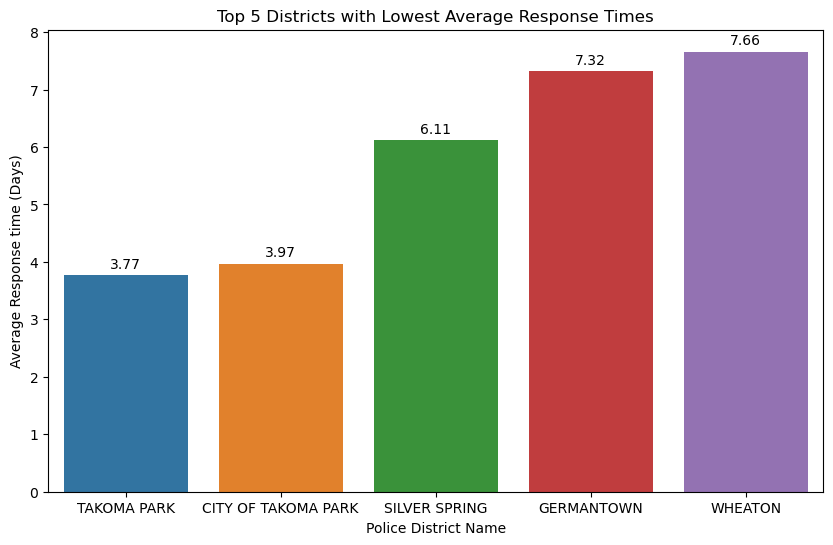

In [133]:
# Create a bar plot using the `top_3_districts` DataFrame
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_districts['Response_time_days'], x= top_districts['Police District Name'], data=top_districts, hue='Police District Name')
plt.xlabel('Police District Names')
plt.ylabel('Mean Response Time (Minutes)')
# Add a title and labels for the x-axis and y-axis
plt.title('Top 5 Districts with Lowest Average Response Times')
plt.xlabel('Police District Name')
plt.ylabel('Average Response time (Days)')

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline',
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')
    
# Display the plot
plt.show()

#Visualisation 2

In [141]:
def aggregate(df):
    df_D_filtered = df[df['Police District Name'].isin(['TAKOMA PARK', 'CITY OF TAKOMA PARK', 'SILVER SPRING', 'GERMANTOWN', 'WHEATON'])]
    # Aggregate the filtered DataFrame by `Police District Name` and `Crime Type` and compute the mean of `Response_time_sec`
    df_D_agg = df_D_filtered.groupby(['Police District Name', 'Crime Type'])['Response_time_days'].mean().sort_values().reset_index()
    # Add `Response_time_min` column to the aggregated DataFrame by dividing `Response_time_sec` by 60
    return df_D_agg

In [143]:
df_D_agg = aggregate(df_D)

KeyError: 'Crime Type'

In [145]:
df_D

,Incident ID,Dispatch Date / Time,NIBRS Code,Crime Name1,Crime Name2,Police District Name,City,Place,Street Name,Start_Date_Time,Latitude,Longitude,Response_time,Response_time_days
0,201202980,2018-08-23 21:52:08,35B,Crime Against Society,Drug Equipment Violations,GERMANTOWN,GERMANTOWN,Street,MIDDLEBROOK,2018-08-23 21:52:00,39.177744,-77.265619,8.0,0.000093
1,201181293,2018-03-30 01:00:55,35A,Crime Against Society,Drug/Narcotic Violations,BETHESDA,BETHESDA,Street,WOODMONT,2018-03-30 01:01:00,38.992693,-77.097063,5.0,0.000058
2,201181293,2018-03-30 01:00:55,35A,Crime Against Society,Drug/Narcotic Violations,BETHESDA,BETHESDA,Street,WOODMONT,2018-03-30 01:01:00,38.992693,-77.097063,5.0,0.000058
3,201193163,2018-06-14 22:26:45,35A,Crime Against Society,Drug/Narcotic Violations,MONTGOMERY VILLAGE,GAITHERSBURG,Hotel/Motel/Etc.,QUINCE ORCHARD,2018-06-14 22:26:00,39.147954,-77.218189,45.0,0.000521
4,201204355,2018-09-03 12:06:54,220,Crime Against Property,Burglary/Breaking and Entering,BETHESDA,CHEVY CHASE,Residence,FALSTONE,2018-09-02 23:30:00,38.966174,-77.096561,45414.0,0.525625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306089,201320571,2021-02-21 07:25:28,13B,Crime Against Person,Simple Assault,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,Residence,TRANSHIRE,2021-02-20 20:00:00,39.172701,-77.197340,41128.0,0.476019
306090,201329875,2021-05-06 22:54:47,23F,Crime Against Property,Theft From Motor Vehicle,WHEATON,SILVER SPRING,Parking Lot,ATHERTON,2021-05-06 03:15:00,39.059672,-77.075995,70787.0,0.819294
306091,201329751,2021-05-05 22:38:58,90Z,Crime Against Society,All Other Offenses,GERMANTOWN,GERMANTOWN,Residence,BALTUSROL,2021-05-05 22:38:00,39.199722,-77.273039,58.0,0.000671
306092,201323117,2021-03-13 12:07:14,90Z,Crime Against Society,All Other Offenses,SILVER SPRING,SILVER SPRING,Street,FENTON,2021-03-13 13:35:00,38.985813,-77.022915,5266.0,0.060949


In [149]:
##TODO Add NIBRS LOOKUP FUNCTION HERE